## Can you classify cards?
#### We expect you to use card images with their labels to classify unseen test images. You have to write a dataloader to read images from the folder 'cards/', write a CNN class, a loss function, a training loop, and check your test accuracy.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data in the folder 'cards/').

In [ ]:
!wget https://www.dropbox.com/s/gxcflnuuq0a64wx/cards.zip

!unzip cards.zip

!ls

### Dataloader
#####  Training and testing data sets are given in the folder 'cards/'. The training data is given as a folder of jpg images and a csv file that contain the class names associated with every image file. The testing data is also given in the same way. The class names can be turned into integer labels using the python dictionary below.

In [ ]:
C = 53  # number of classes
class_names = ['ace of spades', 'seven of clubs', 'jack of clubs', 'two of clubs', 'queen of hearts',
               'two of hearts', 'four of diamonds', 'queen of clubs', 'ten of spades', 'eight of diamonds',
               'three of clubs', 'eight of hearts', 'three of diamonds', 'five of hearts', 'six of clubs',
               'ten of diamonds', 'nine of clubs', 'ten of hearts', 'six of diamonds', 'king of diamonds',
               'nine of hearts', 'eight of clubs', 'seven of hearts', 'five of spades', 'five of diamonds',
               'four of hearts', 'queen of spades', 'four of spades', 'king of hearts', 'jack of spades',
               'seven of diamonds', 'three of spades', 'jack of diamonds', 'six of spades', 'ace of hearts',
               'king of clubs', 'nine of diamonds', 'ace of diamonds', 'eight of spades', 'nine of spades',
               'queen of diamonds', 'jack of hearts', 'joker', 'two of diamonds', 'ten of clubs', 'seven of spades',
               'two of spades', 'five of clubs', 'ace of clubs', 'six of hearts', 'king of spades', 'four of clubs',
               'three of hearts']
names_to_labels = dict(zip(class_names, list(range(C))))

Write dataloaders that return images and labels for both the testing and training datasets. Use the transform below to resize the images to 56x56.

In [ ]:
resize = transforms.Resize([32,32])
affine = transforms.RandomAffine(30)
class MyDataset(Dataset):
  def __init__(self, im_fol, csv_file, trans = None):
    super().__init__()
    df = pd.read_csv(csv_file)
    self.im_list = df["image_name"].to_list()
    self.labels = df["class_name"].to_list()
    self.im_fol = im_fol
    self.trans = trans

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    im = Image.imread(f"{self.im_fol}{self.im_list[idx]}")
    im = np.array(im)
    if self.trans:
      im = self.trans(im)

    label = names_to_labels[self.labels[idx]]
    return im, label

In [ ]:
batch_sz= 64 # this is batch size i.e. the number of rows in a batch of data

trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([56,56])])

train_dataset = MyDataset("/content/cards/train_cards/","/content/cards/cards_train.csv", trans=trans)
test_dataset =  MyDataset("/content/cards/test_cards/","/content/cards/cards_test.csv", trans=trans)

train_loader = DataLoader(train_dataset, batch_size = batch_sz)
test_loader = DataLoader(test_dataset, batch_size = batch_sz)

print(len(train_loader))

120


#### Visualize the data
##### Get a batch from the dataloader, show its images, and print their corresponding labels and/or names

<ipython-input-152-147d1f0712fe>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.im_fol}{self.im_list[idx]}")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the cal

torch.Size([64, 3, 56, 56])


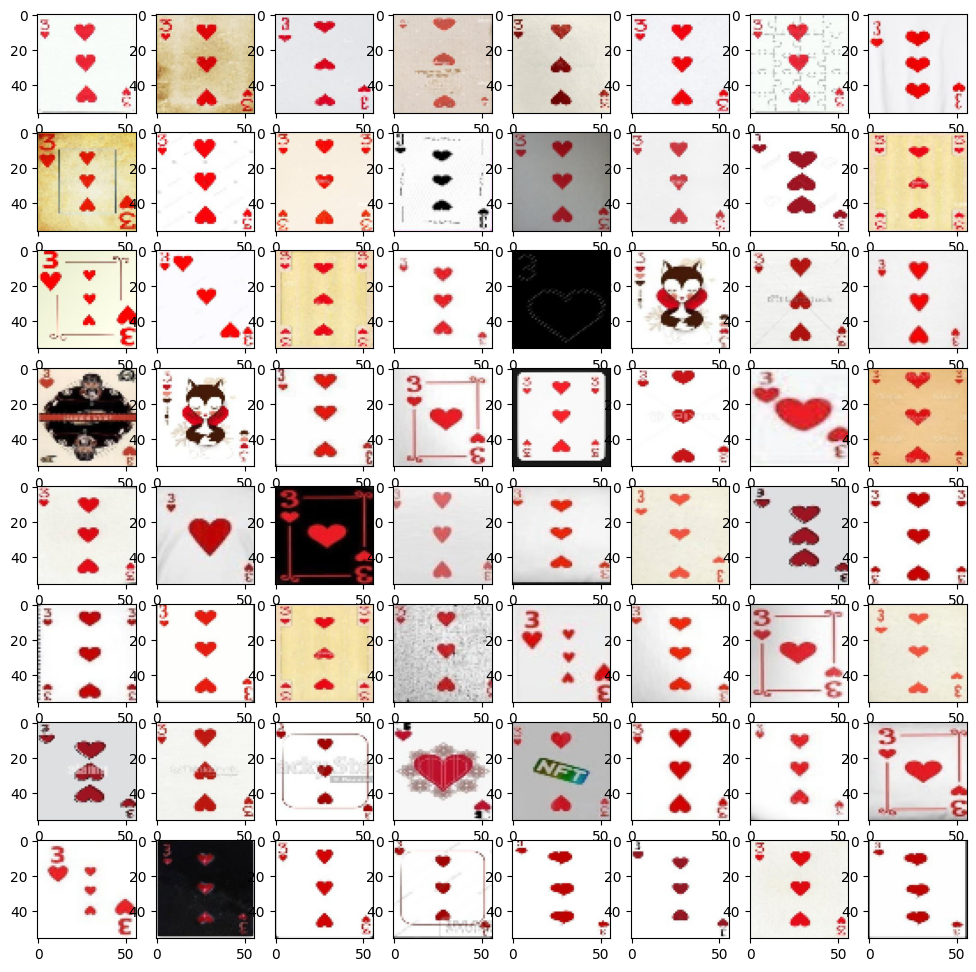

In [ ]:
batch = next(iter(train_loader))
print(batch[0].shape)

# ADD CODE HERE
plt.figure(figsize=(12,12))
for i in range(64):
  plt.subplot(8,8, i+1)
  plt.imshow(train_dataset[i][0][:,:,:].permute(1,2,0))


### Define a CNN
#### Generate a CNN for the classification task in the cell below. You may either use an existing network (ResNet18, VGG11, etc.) and modify it as needed, or build your own network from scratch.

In [ ]:
# ADD CODE HERE
class My_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # first convolutional layer
    # params: 3 input channel, 20 output channels, 3x3 filter, 1-step stride, 1-size padding
    self.conv1 = nn.Conv2d(3,20,3,1,1)
    # second convolutioal layer
    # params: 20 input channels (output of last layer), 50 output channels, 3x3 filter, 1-step stride, padding
    self.conv2 = nn.Conv2d(20,50,3,1,1)
    # first linear layer
    # params: input=output of last layer * size after maxpooling (7*7), output=100 (design choice)
    self.linear1 = nn.Linear(50*14*14,100)
    # second linear layer
    # params: output of last layer, output=10 (num of digits)
    self.linear2 = nn.Linear(100,53)

  def forward(self,x):
    # feature extractor
    #Now: x -> 1, 32, 32
    # apply conv1 layer then call the activation function relu
    x = self.conv1(x)
    x = torch.relu(x)
    #Now: x -> 20, 32, 32
    # apply max pooling
    x = F.max_pool2d(x,(2,2))
    #Now: x -> 20, 16, 16
    # apply conv2 layer then call the activation function relu
    x = self.conv2(x)
    x = torch.relu(x)
    #Now: x -> 50, 16, 16
    x = F.max_pool2d(x, (2,2))
    #Now: x -> 50, 8, 8
    # alter the view
    x = x.view(-1, 50*14*14)
    # apply first linear layer then call the activation function relu
    x = self.linear1(x)
    x = torch.relu(x)
    # apply second linear layer
    x = self.linear2(x)
    return x

## Loss
#### Define Loss function in the following cell

In [ ]:
# ADD CODE HERE
#written in the next cell

torch.Size([64, 3, 56, 56])

### Training loop
#### Define an optimizer, write the training loop in the following cell, and plot the loss

<ipython-input-152-147d1f0712fe>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.im_fol}{self.im_list[idx]}")


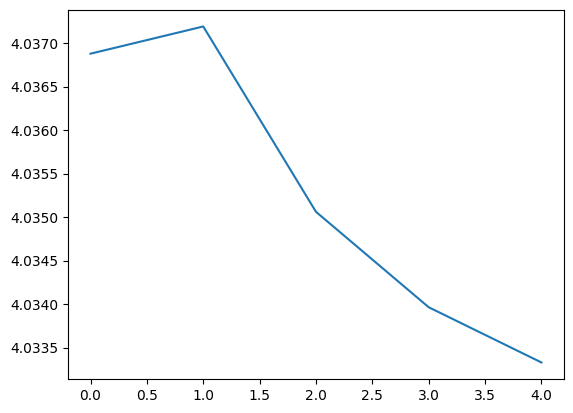

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the question marks '?' and add code where needed
model = My_CNN().to(device)
num_epochs = 5
lr = 0.05
momentum = 0.5
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

ls=[] ####################3

for i in range(num_epochs):
  total_loss=0 #######################################
  for batch in train_loader:
    # ADD CODE HERE
    # extracting data and labels from batch, go to the GPU
    X,y = batch[0].to(device) , batch[1].to(device)
    # doing the forward pass through the networks
    y_hat = model(X)
    # calculating the loss
    loss = F.cross_entropy(y_hat, y)
    # emptying the buffers to store the gradients
    opt.zero_grad()
    # backward pass to calculate the gradient
    loss.backward()
    # optimizing, taking a step in the negative gradient direction
    opt.step()
    # increment total_loss
    total_loss += loss.item()
  # append total_loss to the array
  ls.append(total_loss/len(train_loader))

plt.plot(ls);

In [ ]:
#### more optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the question marks '?' and add code where needed
model = My_CNN().to(device)
num_epochs = 15
lr = 1e-2
momentum = 0.5
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

ls=[] ####################3

for i in range(num_epochs):
  total_loss=0 #######################################
  for batch in train_loader:
    # ADD CODE HERE
    # extracting data and labels from batch, go to the GPU
    X,y = batch[0].to(device) , batch[1].to(device)
    # doing the forward pass through the networks
    y_hat = model(X)
    # calculating the loss
    loss = F.cross_entropy(y_hat, y)
    # emptying the buffers to store the gradients
    opt.zero_grad()
    # backward pass to calculate the gradient
    loss.backward()
    # optimizing, taking a step in the negative gradient direction
    opt.step()
    # increment total_loss
    total_loss += loss.item()
  # append total_loss to the array
  ls.append(total_loss/len(train_loader))

plt.plot(ls);

## Check test accuracy

In [ ]:
# ADD CODE HERE
correct = 0
total = 0
list_y = []
list_yhat = []

with torch.no_grad():
  for batch in test_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    yhat = model(X)
    labels = torch.argmax(yhat, dim =1 )
    correct += torch.sum(y == labels)
    total += y.shape[0]
    list_y.extend(y.cpu().numpy())
    list_yhat.extend(labels.cpu().numpy())

print("Accuracy for my model = ", correct/total)


list_y = np.array(list_y)
list_yhat = np.array(list_yhat)


<ipython-input-152-147d1f0712fe>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.im_fol}{self.im_list[idx]}")


Accuracy for my model =  tensor(0.0189)
